In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

2025-10-24 12:44:53.942916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
BATCH_SIZE = 10   #FIX THIS TO MATCH YOUR GPU LIMITS
MIXED_PRECISION = False #SET THIS FALSE AND I COMMENTED THE IF STATEMENT BELOW
SHUFFLE = True

# Mixed-precision setting
#if MIXED_PRECISION:
    #policy = keras.mixed_precision.Policy("mixed_float16")
    #keras.mixed_precision.set_global_policy(policy)

In [3]:
(train_ds, valid_ds, test_ds) = tfds.load(
    "oxford_iiit_pet",
    split=["train[:85%]", "train[85%:]", "test"],
    batch_size=BATCH_SIZE,
    shuffle_files=SHUFFLE,
)

I0000 00:00:1761302696.222467   21931 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8823 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [4]:
# Image and Mask Pre-processing
def unpack_resize_data(section):
    image = section["image"]
    segmentation_mask = section["segmentation_mask"]

    resize_layer = keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH)

    image = resize_layer(image)
    segmentation_mask = resize_layer(segmentation_mask)

    return image, segmentation_mask


train_ds = train_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)

2025-10-24 12:44:56.680217: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


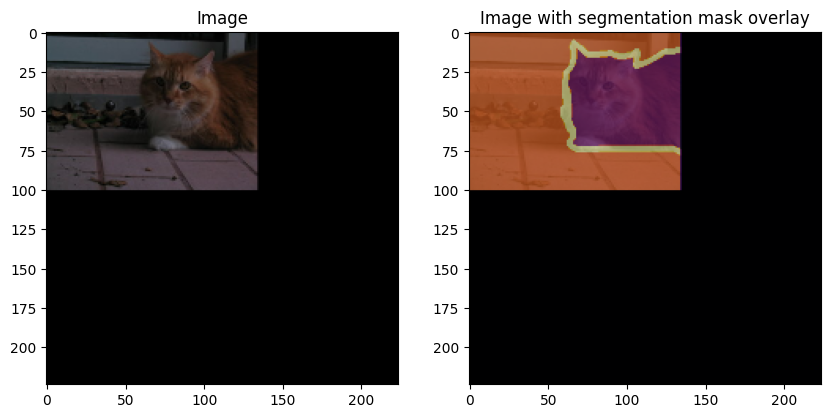

In [5]:
# Select random image and mask. Cast to NumPy array
# for Matplotlib visualization.

images, masks = next(iter(test_ds))
random_idx = keras.random.uniform([], minval=0, maxval=BATCH_SIZE, seed=10)

test_image = images[int(random_idx)].numpy().astype("float")
test_mask = masks[int(random_idx)].numpy().astype("float")

# Overlay segmentation mask on top of image.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set_title("Image")
ax[0].imshow(test_image / 255.0)

ax[1].set_title("Image with segmentation mask overlay")
ax[1].imshow(test_image / 255.0)
ax[1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)
plt.show()

In [6]:
def preprocess_data(image, segmentation_mask):
    image = keras.applications.vgg19.preprocess_input(image)

    return image, segmentation_mask


train_ds = (
    train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)
valid_ds = (
    valid_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)
test_ds = (
    test_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)

In [7]:
input_layer = keras.Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))

# VGG Model backbone with pre-trained ImageNet weights.
vgg_model = keras.applications.vgg19.VGG19(include_top=True, weights="imagenet")

# Extracting different outputs from same model
fcn_backbone = keras.models.Model(
    inputs=vgg_model.layers[1].input,
    outputs=[
        vgg_model.get_layer(block_name).output
        for block_name in ["block3_pool", "block4_pool", "block5_pool"]
    ],
)

# Setting backbone to be non-trainable
fcn_backbone.trainable = False

x = fcn_backbone(input_layer)

# Converting Dense layers to Conv2D layers
units = [4096, 4096]
dense_convs = []

for filter_idx in range(len(units)):
    dense_conv = keras.layers.Conv2D(
        filters=units[filter_idx],
        kernel_size=(7, 7) if filter_idx == 0 else (1, 1),
        strides=(1, 1),
        activation="relu",
        padding="same",
        use_bias=False,
        kernel_initializer=keras.initializers.Constant(1.0),
    )
    dense_convs.append(dense_conv)
    dropout_layer = keras.layers.Dropout(0.5)
    dense_convs.append(dropout_layer)

dense_convs = keras.Sequential(dense_convs)
dense_convs.trainable = False

x[-1] = dense_convs(x[-1])

pool3_output, pool4_output, pool5_output = x

In [8]:
# 1x1 convolution to set channels = number of classes
pool5 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="relu",
)

# Get Softmax outputs for all classes
fcn32s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn32s_upsampling = keras.layers.UpSampling2D(
    size=(32, 32),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

final_fcn32s_pool = pool5(pool5_output)
final_fcn32s_output = fcn32s_conv_layer(final_fcn32s_pool)
final_fcn32s_output = fcn32s_upsampling(final_fcn32s_output)

fcn32s_model = keras.Model(inputs=input_layer, outputs=final_fcn32s_output)

In [9]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool4 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="linear",
    kernel_initializer=keras.initializers.Zeros(),
)(pool4_output)

# Intermediate up-sample
pool5 = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)(final_fcn32s_pool)

# Get Softmax outputs for all classes
fcn16s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn16s_upsample_layer = keras.layers.UpSampling2D(
    size=(16, 16),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

# Add intermediate outputs
final_fcn16s_pool = keras.layers.Add()([pool4, pool5])
final_fcn16s_output = fcn16s_conv_layer(final_fcn16s_pool)
final_fcn16s_output = fcn16s_upsample_layer(final_fcn16s_output)

fcn16s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn16s_output)

In [10]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool3 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="linear",
    kernel_initializer=keras.initializers.Zeros(),
)(pool3_output)

# Intermediate up-sample
intermediate_pool_output = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)(final_fcn16s_pool)

# Get Softmax outputs for all classes
fcn8s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn8s_upsample_layer = keras.layers.UpSampling2D(
    size=(8, 8),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

# Add intermediate outputs
final_fcn8s_pool = keras.layers.Add()([pool3, intermediate_pool_output])
final_fcn8s_output = fcn8s_conv_layer(final_fcn8s_pool)
final_fcn8s_output = fcn8s_upsample_layer(final_fcn8s_output)

fcn8s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn8s_output)

In [11]:
# VGG's last 2 layers
weights1 = vgg_model.get_layer("fc1").get_weights()[0]
weights2 = vgg_model.get_layer("fc2").get_weights()[0]

weights1 = weights1.reshape(7, 7, 512, 4096)
weights2 = weights2.reshape(1, 1, 4096, 4096)

dense_convs.layers[0].set_weights([weights1])
dense_convs.layers[2].set_weights([weights2])

In [12]:
fcn32s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

fcn32s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn32s_model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn32s_history = fcn32s_model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

Epoch 1/20


2025-10-24 12:45:04.942945: I external/local_xla/xla/service/service.cc:163] XLA service 0x74d59c005ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 12:45:04.942958: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-24 12:45:04.985824: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-24 12:45:05.080193: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-10-24 12:45:05.235547: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-10-24 12:45:05.454604: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy

  4/313 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 1.5437 - mean_io_u: 0.0814 - sparse_categorical_accuracy: 0.1590

I0000 00:00:1761302710.767534   22045 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/313 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 1.3128 - mean_io_u: 0.2346 - sparse_categorical_accuracy: 0.4390

2025-10-24 12:45:24.683690: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-10-24 12:45:24.929138: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-24 12:45:25.256334: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optima

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.2836 - mean_io_u: 0.2549 - sparse_categorical_accuracy: 0.4732

2025-10-24 12:45:43.137142: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-10-24 12:45:47.094454: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-10-24 12:45:47.430640: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-24 12:45:47.616095: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-24 12:45:48.120572: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Dela

313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - loss: 1.2025 - mean_io_u: 0.3077 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.0594 - val_mean_io_u: 0.3830 - val_sparse_categorical_accuracy: 0.6658
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - loss: 0.9455 - mean_io_u: 0.3877 - sparse_categorical_accuracy: 0.6673 - val_loss: 0.7452 - val_mean_io_u: 0.4343 - val_sparse_categorical_accuracy: 0.7083
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - loss: 0.7652 - mean_io_u: 0.4039 - sparse_categorical_accuracy: 0.6898 - val_loss: 0.7045 - val_mean_io_u: 0.4453 - val_sparse_categorical_accuracy: 0.7267
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - loss: 0.7418 - mean_io_u: 0.4132 - sparse_categorical_accuracy: 0.6994 - val_loss: 0.6916 - val_mean_io_u: 0.4409 - val_sparse_categorical_accuracy: 0.7265
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - loss: 0.7317 - mean_io_u: 0.4169 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.7029 - val_mean_io_u

In [13]:
fcn16s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

fcn16s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn16s_model.compile(
    optimizer=fcn16s_optimizer,
    loss=fcn16s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn16s_history = fcn16s_model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

Epoch 1/20


2025-10-24 12:57:25.853101: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


122/313 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 2.2915 - mean_io_u_1: 0.4918 - sparse_categorical_accuracy: 0.7487

2025-10-24 12:57:35.864503: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.8248 - mean_io_u_1: 0.5366 - sparse_categorical_accuracy: 0.7979

2025-10-24 12:57:54.865097: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-10-24 12:57:55.953314: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - loss: 1.4606 - mean_io_u_1: 0.5743 - sparse_categorical_accuracy: 0.8382 - val_loss: 1.3412 - val_mean_io_u_1: 0.5948 - val_sparse_categorical_accuracy: 0.8552
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - loss: 1.3111 - mean_io_u_1: 0.5956 - sparse_categorical_accuracy: 0.8590 - val_loss: 1.3444 - val_mean_io_u_1: 0.5953 - val_sparse_categorical_accuracy: 0.8557
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - loss: 1.2963 - mean_io_u_1: 0.5983 - sparse_categorical_accuracy: 0.8610 - val_loss: 1.3227 - val_mean_io_u_1: 0.5977 - val_sparse_categorical_accuracy: 0.8575
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - loss: 1.2898 - mean_io_u_1: 0.5988 - sparse_categorical_accuracy: 0.8614 - val_loss: 1.3209 - val_mean_io_u_1: 0.5984 - val_sparse_categorical_accuracy: 0.8578
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - loss: 1.2922 - mean_io_u_1: 0.5980 - sparse_categorical_accuracy: 0.8606 - val_loss: 1

In [14]:
fcn8s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

fcn8s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn8s_model.compile(
    optimizer=fcn8s_optimizer,
    loss=fcn8s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn8s_history = fcn8s_model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

Epoch 1/20


2025-10-24 13:09:29.961776: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


302/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 12.8945 - mean_io_u_2: 0.0733 - sparse_categorical_accuracy: 0.1827

2025-10-24 13:09:55.767135: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 12.8814 - mean_io_u_2: 0.0737 - sparse_categorical_accuracy: 0.1833

2025-10-24 13:09:59.365207: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-10-24 13:10:00.263630: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 12.5084 - mean_io_u_2: 0.0865 - sparse_categorical_accuracy: 0.2002 - val_loss: 12.1608 - val_mean_io_u_2: 0.0946 - val_sparse_categorical_accuracy: 0.2125
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - loss: 12.2842 - mean_io_u_2: 0.0918 - sparse_categorical_accuracy: 0.2069 - val_loss: 12.1338 - val_mean_io_u_2: 0.0956 - val_sparse_categorical_accuracy: 0.2155
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - loss: 12.2629 - mean_io_u_2: 0.0932 - sparse_categorical_accuracy: 0.2088 - val_loss: 12.1308 - val_mean_io_u_2: 0.0961 - val_sparse_categorical_accuracy: 0.2160
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - loss: 10.9044 - mean_io_u_2: 0.1497 - sparse_categorical_accuracy: 0.2774 - val_loss: 1.1453 - val_mean_io_u_2: 0.6367 - val_sparse_categorical_accuracy: 0.8236
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - loss: 0.9079 - mean_io_u_2: 0.6663 - sparse_categorical_accuracy: 0.8584 - val_l

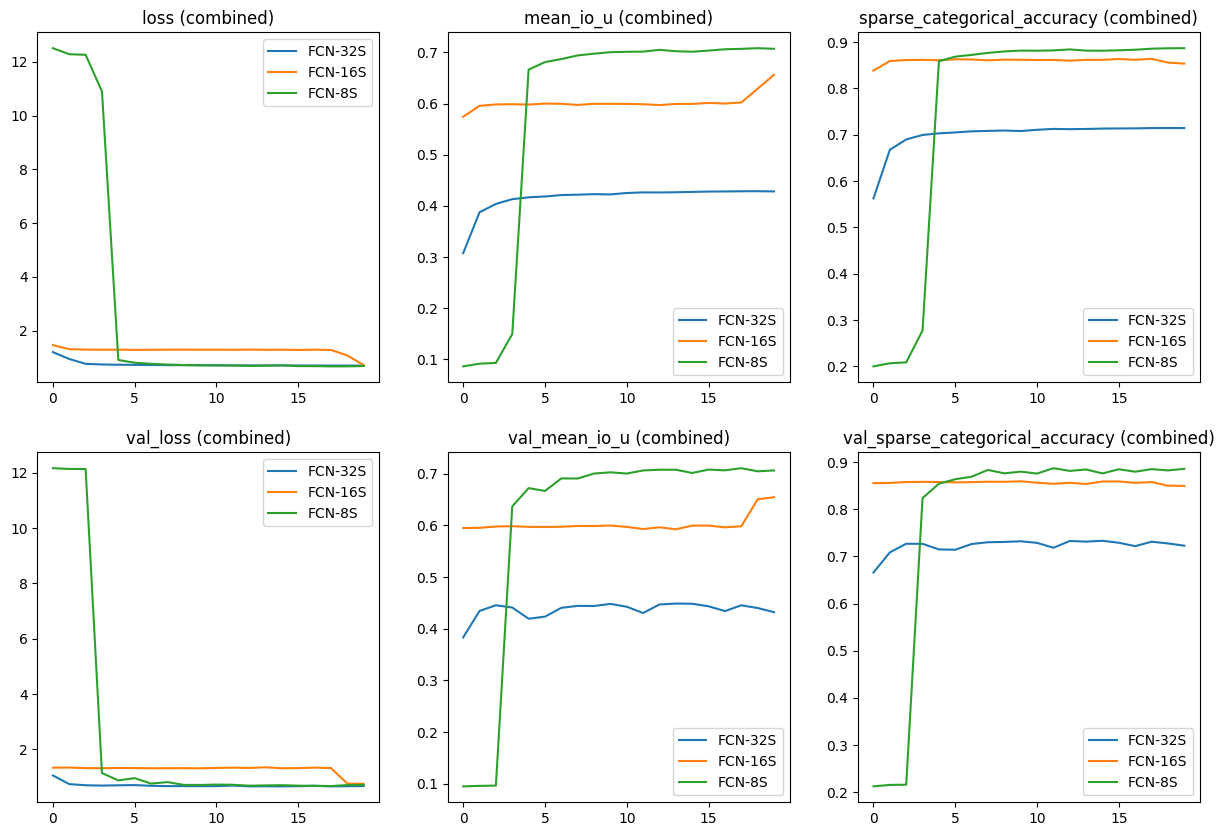

In [15]:
total_plots = len(fcn32s_history.history)
cols = total_plots // 2

rows = total_plots // cols

if total_plots % cols != 0:
    rows += 1

# Set all history dictionary objects
fcn32s_dict = fcn32s_history.history
fcn16s_dict = fcn16s_history.history
fcn8s_dict = fcn8s_history.history

pos = range(1, total_plots + 1)
plt.figure(figsize=(15, 10))

for i, ((key_32s, value_32s), (key_16s, value_16s), (key_8s, value_8s)) in enumerate(
    zip(fcn32s_dict.items(), fcn16s_dict.items(), fcn8s_dict.items())
):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value_32s)), value_32s)
    plt.plot(range(len(value_16s)), value_16s)
    plt.plot(range(len(value_8s)), value_8s)
    plt.title(str(key_32s) + " (combined)")
    plt.legend(["FCN-32S", "FCN-16S", "FCN-8S"])

plt.show()

2025-10-24 13:21:40.988168: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-24 13:21:41.178666: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-24 13:21:41.203606: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,112,112]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv

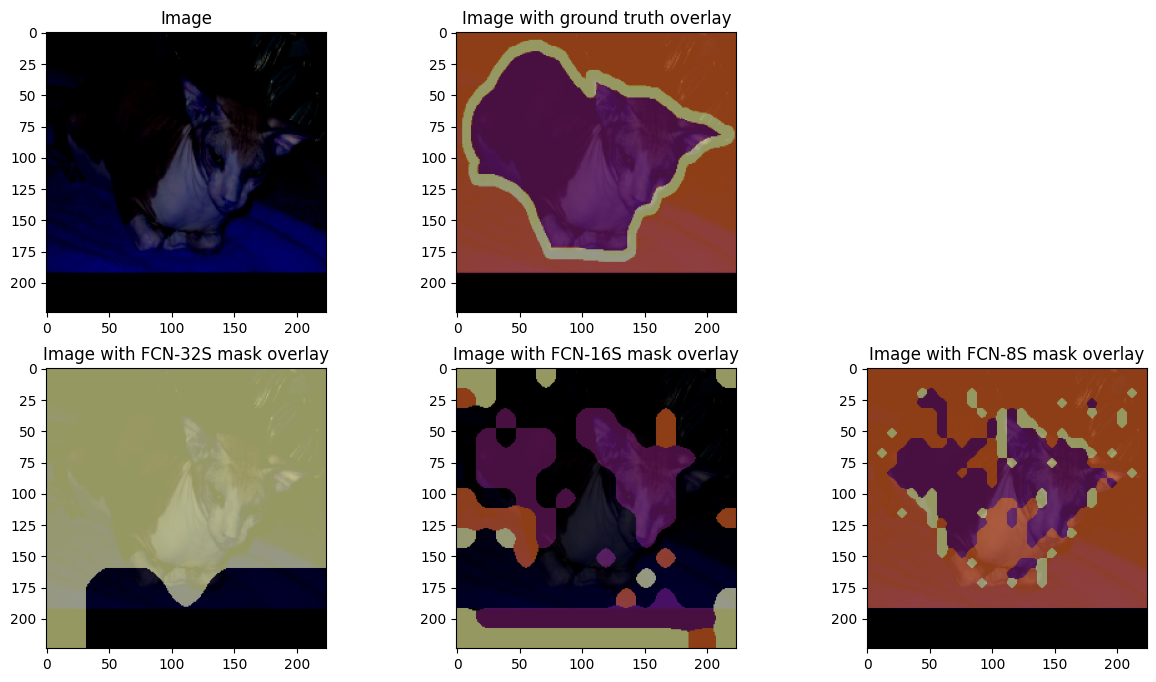

In [16]:
images, masks = next(iter(test_ds))
random_idx = keras.random.uniform([], minval=0, maxval=BATCH_SIZE,seed=10)

# Get random test image and mask
test_image = images[int(random_idx)].numpy().astype("float")
test_mask = masks[int(random_idx)].numpy().astype("float")

pred_image = ops.expand_dims(test_image, axis=0)
pred_image = keras.applications.vgg19.preprocess_input(pred_image)

# Perform inference on FCN-32S
pred_mask_32s = fcn32s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_32s = np.argmax(pred_mask_32s, axis=-1)
pred_mask_32s = pred_mask_32s[0, ...]

# Perform inference on FCN-16S
pred_mask_16s = fcn16s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_16s = np.argmax(pred_mask_16s, axis=-1)
pred_mask_16s = pred_mask_16s[0, ...]

# Perform inference on FCN-8S
pred_mask_8s = fcn8s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_8s = np.argmax(pred_mask_8s, axis=-1)
pred_mask_8s = pred_mask_8s[0, ...]

# Plot all results
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

fig.delaxes(ax[0, 2])

ax[0, 0].set_title("Image")
ax[0, 0].imshow(test_image / 255.0)

ax[0, 1].set_title("Image with ground truth overlay")
ax[0, 1].imshow(test_image / 255.0)
ax[0, 1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)

ax[1, 0].set_title("Image with FCN-32S mask overlay")
ax[1, 0].imshow(test_image / 255.0)
ax[1, 0].imshow(pred_mask_32s, cmap="inferno", alpha=0.6)

ax[1, 1].set_title("Image with FCN-16S mask overlay")
ax[1, 1].imshow(test_image / 255.0)
ax[1, 1].imshow(pred_mask_16s, cmap="inferno", alpha=0.6)

ax[1, 2].set_title("Image with FCN-8S mask overlay")
ax[1, 2].imshow(test_image / 255.0)
ax[1, 2].imshow(pred_mask_8s, cmap="inferno", alpha=0.6)

plt.show()